This notebook contains the code for my final autoencoder. It includes the initial preproccessing of the data, the design and training of the model and all further analysis. This inlcudes application to multiple types of signal to ensure that the autoencoder is working as expected for all datatypes. 

This code was initially based off the neural network example in the [machine learning tutorial](https://colab.research.google.com/github/yanncoadou/MLtutorials/blob/main/ML_IDPASC2021.ipynb) and the tutorial for anomaly detection using autoneneocoders on the [tensor flow website](https://www.tensorflow.org/tutorials/generative/autoencoder).
However, I then made alot of edits and extensions to these examples so that they were adequate for the purpose which I required.

I initially developed this code using several different notebooks which contained multiple tests and different attempts. However, when I was having issues and finding errors I followed my supervisors advice and created a clean notebook containing only the sections which I needed. This is the final product and contains all code which I used to design and analyse my autoencoder.

# Standard Imports

In [1]:
#importing relevant modules 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_circles
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [51]:
def my_plot_roc_curve(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    else:
        y_scores = model.predict(X_test)

    if len(y_scores.shape) == 2:
        if y_scores.shape[1] == 1:
            y_scores = y_scores.reshape(-1)
        elif y_scores.shape[1] == 2:
            y_scores = y_scores[:,1].reshape(-1)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    plt.clf()
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.__class__.__name__)
    display.plot()
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.savefig("Roc Curve.pdf")
    plt.show()

# Loading the Datasets
A background dataset was used to represent standard model events.

Four different simulated signal datasets were used. These are as follows:
* ResmMed4000mX1lb0p2yp0p4: This is the monotop signal
* GG direct 2000 0: This is a SUSY signal of guino g pair production with gluon decay to quarks and neutrino
* HVT Agv1 VzZH vvqq m1000: This is a heavy vector triplet production, with heavy vector decay
* bbA2000 yb2 Zhvvbb: This is the Two Higgs Doublet Model (2HDM) process with production of heavy pseudoscalar A associated with 2 b-quarks

Each of these were loaded into the dataset.

In [2]:
monotopSignal=pd.read_csv('ResmMed4000mX1lb0p2yp0p4.csv',delimiter=',',index_col=0) 
print("Signal loaded")

Signal loaded


In [3]:
guinoSignal=pd.read_csv('GG_direct_2000_0.csv',delimiter=',',index_col=0) 

In [4]:
tripletSignal=pd.read_csv('HVT_Agv1_VzZH_vvqq_m1000.csv',delimiter=',',index_col=0) 

In [5]:
higgsSignal=pd.read_csv('bbA2000_yb2_Zhvvbb.csv',delimiter=',',index_col=0) 

In [6]:
background=pd.read_csv('bkg.csv',delimiter=',',index_col=0)
print("Background loaded")

Background loaded


# Selecting features to train on

Not all of the sigbals had the same features in. In order to apply the model to all different signals, only the common features could be used to train the autoencoder. In order to do this, only the features that were present in all signals were selected to train on.

In [7]:
tripletSignal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8311 entries, 210000 to 219999
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jet_DL1r_max              8311 non-null   float64
 1   normalisedCombinedWeight  8311 non-null   float64
 2   jet_e                     8311 non-null   float64
 3   mcChannelNumber           8311 non-null   int64  
 4   topjet_pt                 8311 non-null   float64
 5   MET_eta                   8311 non-null   float64
 6   topjet_e                  8311 non-null   float64
 7   ljet_m                    8311 non-null   float64
 8   nLumi                     8311 non-null   float64
 9   MET                       8311 non-null   float64
 10  topjet_phi                8311 non-null   float64
 11  jet_eta                   8311 non-null   float64
 12  ljet_py                   8311 non-null   float64
 13  ljet_phi                  8311 non-null   float64
 14  ljet_p

In [8]:
newBackground=pd.DataFrame(background,columns=tripletSignal.columns)
newSignal=pd.DataFrame(monotopSignal,columns=tripletSignal.columns)

# Splitting the dataset

The dataset had to be split into test, train and validation datasets. This has to be done for both signal and background which must be kept separate as the autoencoder can only be trained on background. The train datset is used to train the model on and is what it learns the separation from. The validation dataset is then used during training to prevent overfitting (when the model just starts to memorise the training dataset rather than learning how it is made up)and to adjust the model as training takes place. The test dataset is then used to test the model as it applies it to data which has never been seen before. This demonstartes how the model acts when it is applied to new data. 

The weights for each of these datasets then had to be spearated.

Certain columns which contained string datatypes or irrelevant information were then dropped to minimse the datset. 

In [9]:
#separating background data
testBackground=newBackground.loc[newBackground['gen_split'] == 'test']
trainBackground=newBackground.loc[newBackground['gen_split'] == 'train']
validBackground=newBackground.loc[newBackground['gen_split'] == 'val']
print("Background data separated")


#separating signal data
testSignalM=newSignal.loc[newSignal['gen_split'] == 'test']
trainSignalM=newSignal.loc[newSignal['gen_split'] == 'train']
validSignalM=newSignal.loc[newSignal['gen_split'] == 'val']

testSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'test']
trainSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'train']
validSignalG=guinoSignal.loc[guinoSignal['gen_split'] == 'val']

testSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'test']
trainSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'train']
validSignalT=tripletSignal.loc[tripletSignal['gen_split'] == 'val']

testSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'test']
trainSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'train']
validSignalH=higgsSignal.loc[higgsSignal['gen_split'] == 'val']

print("Signal data separated")


#retrieving background weights
testWeightsBackground=testBackground['train_weight']
trainWeightsBackground=trainBackground['train_weight']
validWeightsBackground=validBackground['train_weight']
print("Background weights retrieved")

#dropping unnecessary columns from separated sets

testBackground=testBackground.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
trainBackground=trainBackground.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
validBackground=validBackground.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

testSignalM=testSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
trainSignalM=trainSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
validSignalM=validSignalM.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

testSignalG=testSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
trainSignalG=trainSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
validSignalG=validSignalG.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

testSignalT=testSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
trainSignalT=trainSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
validSignalT=validSignalT.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

testSignalH=testSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
trainSignalH=trainSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')
validSignalH=validSignalH.drop(['normalisedCombinedWeight','gen_split','train_weight','combinedWeight','squaredCombinedWeight','gen_sample','category','merge_sample','positiveCombinedWeight','MET_m','MET_eta','mcChannelNumber','mc_channel','nLumi','topjet_phi', 'mtop', 'topjet_eta', 'topjet_m'],axis='columns')

print("Columns dropped")


Background data separated
Signal data separated
Background weights retrieved
Columns dropped


In [43]:
#Defining Labels for each dataset
testSignalMLabel=np.ones(len(testSignalM))
testSignalHLabel=np.ones(len(testSignalH))
testSignalGLabel=np.ones(len(testSignalG))
testSignalTLabel=np.ones(len(testSignalT))
testBackgroundLabel=np.zeros(len(testBackground))

# Standardising data

The data must be standardised before training can commence. This involves applying a transformation to the data such that the mean becomes 0 and the standard deviation 1. This ensures that features dont have a higher relative importance just from numerically higher values, but rather only an importance which is refelctive of the true importance. The standardisation is calculated below for the training background dataset. 

In [10]:
from sklearn.preprocessing import StandardScaler

print("Original mean and variance:")
for feature, mean, std in zip(trainBackground.columns,trainBackground.mean(0), trainBackground.std(0)):
    print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))

scaler = StandardScaler()
trainBackground_scaled = scaler.fit_transform(trainBackground)



print("\nStandardised mean and variance:")
for feature, mean, std in zip(trainBackground.columns,trainBackground_scaled.mean(0), trainBackground_scaled.std(0)):
    print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))



Original mean and variance:
jet_DL1r_max:  0.2569 +/-  3.4291
jet_e    : 698.2610 +/- 424.8866
topjet_pt: -970.2443 +/- 211.3899
topjet_e : -965.2484 +/- 250.1599
ljet_m   : 63.6116 +/- 64.4217
MET      : 420.6880 +/- 146.6124
jet_eta  : -0.0090 +/-  0.9737
ljet_py  :  2.8156 +/- 366.9482
ljet_phi :  0.0115 +/-  1.8142
ljet_pz  : -5.3815 +/- 638.0405
DeltaR_max:  2.3778 +/-  1.4432
ljet_eta : -0.0090 +/-  0.9608
ljet_pt  : 475.9438 +/- 204.1538
jet_pt   : 452.9058 +/- 209.1884
MET_px   :  0.8456 +/- 314.9951
MET_Phi  : -0.0146 +/-  1.8100
jet_pz   : -5.0986 +/- 645.8425
MET_py   : -3.0400 +/- 315.0266
jet_py   :  3.0931 +/- 353.5471
Centrality:  0.7587 +/-  0.1576
jet_px   : -1.0216 +/- 351.9621
ljet_e   : 726.7014 +/- 394.2431
jet_phi  :  0.0124 +/-  1.8142
ljet_px  : -1.1067 +/- 365.4329
HT       : 1115.6198 +/- 473.4075
Omega    : -0.0198 +/-  0.1360

Standardised mean and variance:
jet_DL1r_max:  0.0000 +/-  1.0000
jet_e    :  0.0000 +/-  1.0000
topjet_pt:  0.0000 +/-  1.0000
topje

The same standardisation transformation which has been calculated above has then been applied to all other split datasets. This ensures that they are all of the same relative importance, and by applying the same to each means that they have all been changed in the same way.

In [11]:
#scaling the rest of the data according to the train scale
    
testBackground_scaled = scaler.transform(testBackground)
validBackground_scaled = scaler.transform(validBackground)
testSignalM_scaled=scaler.transform(testSignalM)
trainSignalM_scaled=scaler.transform(trainSignalM)
validSignalM_scaled=scaler.transform(validSignalM)
testSignalG_scaled=scaler.transform(testSignalG)
trainSignalG_scaled=scaler.transform(trainSignalG)
validSignalG_scaled=scaler.transform(validSignalG)
testSignalT_scaled=scaler.transform(testSignalT)
trainSignalT_scaled=scaler.transform(trainSignalT)
validSignalT_scaled=scaler.transform(validSignalT)
testSignalH_scaled=scaler.transform(testSignalH)
trainSignalH_scaled=scaler.transform(trainSignalH)
validSignalH_scaled=scaler.transform(validSignalH)


The above technique also has the effect of converting all the datasets to numpy arrays without labels. For ease, below the datasets have been converted back to pandas dataframes so that labels can be used to access certain columns.

In [12]:
#re adding dataset labels
testBackground_df = pd.DataFrame(data=testBackground_scaled, columns=testBackground.columns)
trainBackground_df = pd.DataFrame(data=trainBackground_scaled, columns=trainBackground.columns)
valBackground_df = pd.DataFrame(data=validBackground_scaled, columns=validBackground.columns)
testSignalM_df = pd.DataFrame(data=testSignalM_scaled, columns=testSignalM.columns)
trainSignalM_df = pd.DataFrame(data=trainSignalM_scaled, columns=trainSignalM.columns)
validSignalM_df = pd.DataFrame(data=validSignalM_scaled, columns=validSignalM.columns)
testSignalG_df = pd.DataFrame(data=testSignalG_scaled, columns=testSignalG.columns)
trainSignalG_df = pd.DataFrame(data=trainSignalG_scaled, columns=trainSignalG.columns)
validSignalG_df = pd.DataFrame(data=validSignalG_scaled, columns=validSignalG.columns)
testSignalT_df = pd.DataFrame(data=testSignalT_scaled, columns=testSignalT.columns)
trainSignalT_df = pd.DataFrame(data=trainSignalT_scaled, columns=trainSignalT.columns)
validSignalT_df = pd.DataFrame(data=validSignalT_scaled, columns=validSignalT.columns)
testSignalH_df = pd.DataFrame(data=testSignalH_scaled, columns=testSignalH.columns)
trainSignalH_df = pd.DataFrame(data=trainSignalH_scaled, columns=trainSignalH.columns)
validSignalH_df = pd.DataFrame(data=validSignalH_scaled, columns=validSignalH.columns)

# Building and training the model

The autoencoder was built using 5 layers and a latent space of 8. I have specified the input shape of 26 as this is the number of features which I am using. An activation function of relu has been applied to all layers except the final. This ensures that the output will be back in the same order of magnitude as the input. 

I used a loss of mean squared error in training my model. This is something which can be changed so I would like to spend some time experimenting with this and testing which loss function is optimal. 

My learning rate is 0.0001. This defines how much is learnt and carried over between epochs. A small learning rate will mean that less is chnaged between the iterations however this does mean that nore epochs will be required to obtain a good result where the loss has actually been minimised.

I ran my model for 1000 epochs but did implement an early stopping with patience 10 which prevents overfitting and ensures that the model is stopped if loss increases for more than 10 epochs.

The model was trained on background data alone so that this is the only thing which can be reconstructed.

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(26,activation="relu",input_shape=(26,)),
      layers.Dense(16,activation="relu"),
      layers.Dense(8,activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16,activation="relu",input_shape=(8,)),
      layers.Dense(26)])
    
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [14]:
opt = keras.optimizers.legacy.Adam(learning_rate=0.0001)

autoencoder.compile(loss="mse",
              optimizer=opt,
              #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
              weighted_metrics=[tf.keras.metrics.MeanSquaredError()])


In [15]:
tf.config.list_physical_devices()
with tf.device('/GPU:0'):
    history = autoencoder.fit(trainBackground_df, trainBackground_df,
                        epochs=1000,
                        shuffle=True,
                        #validation_split=0.2,   # to be used with train/test split
                        validation_data=(valBackground_df, valBackground_df, validWeightsBackground),
                        batch_size=1024,
                        sample_weight=trainWeightsBackground.values,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/1000
3358/3358 [==============================] - 41s 12ms/step - loss: 3.2486e-07 - mean_squared_error: 1.1169 - val_loss: 2.7998e-07 - val_mean_squared_error: 0.9629
Epoch 2/1000
3358/3358 [==============================] - 36s 11ms/step - loss: 2.5361e-07 - mean_squared_error: 0.8719 - val_loss: 2.3342e-07 - val_mean_squared_error: 0.8028
Epoch 3/1000
3358/3358 [==============================] - 36s 11ms/step - loss: 2.1827e-07 - mean_squared_error: 0.7504 - val_loss: 2.0575e-07 - val_mean_squared_error: 0.7076
Epoch 4/1000
3358/3358 [==============================] - 35s 10ms/step - loss: 1.9489e-07 - mean_squared_error: 0.6701 - val_loss: 1.8568e-07 - val_mean_squared_error: 0.6386
Epoch 5/1000
3358/3358 [==============================] - 35s 10ms/step - loss: 1.7713e-07 - mean_squared_error: 0.6090 - val_loss: 1.6987e-07 - val_mean_squared_error: 0.5842
Epoch 6/1000
3358/3358 [==============================] - 35s 10ms/step - loss: 1.6292e-07 - mean_squared_error: 0.5601 

In [16]:
trainBackground_df.columns

Index(['jet_DL1r_max', 'jet_e', 'topjet_pt', 'topjet_e', 'ljet_m', 'MET',
       'jet_eta', 'ljet_py', 'ljet_phi', 'ljet_pz', 'DeltaR_max', 'ljet_eta',
       'ljet_pt', 'jet_pt', 'MET_px', 'MET_Phi', 'jet_pz', 'MET_py', 'jet_py',
       'Centrality', 'jet_px', 'ljet_e', 'jet_phi', 'ljet_px', 'HT', 'Omega'],
      dtype='object')

# Plotting training loss

Here I have plotted the loss over the time that the network was trained. I grained using the mean squared error loss function which means thi si swhat was minimised. 
I have plotted the losses from both the training and validation datasets. I would expect that the validation would be worse than the training however this is not the case. This is very unexpected so I need to conduct some further tests including sampling of my datasets to ensure that they are being split correctly. 

<function matplotlib.pyplot.show(close=None, block=None)>

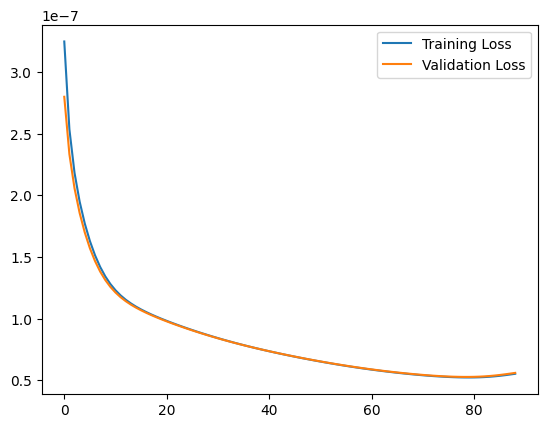

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('Autoencoder loss graph')
plt.show

# Applying model to background data

I then applied the model to my test background dataset. This ensures that it is reconstructing as it should be. These reconstructuions should be very good and the reconstruction errors should be minimal if the model is working correctly.

In [19]:
reconstructedBackground=autoencoder.predict(testBackground_scaled)
print("Model applied")
decoded_df = pd.DataFrame(reconstructedBackground, columns=testBackground.columns)
back_loss = tf.keras.losses.mse(reconstructedBackground, testBackground_scaled)
print("Loss calculated")


107465/107465 [==============================] - 144s 1ms/step
Model applied
Loss calculated


I have plotted the loss graph of the background test set. The shows the mean squared error of th ebackground dataset as it is trained. There are two peaks at higher values which is not expected so I would like to conduct some experiments with my data to find which datapoint sthese correspind to and what is causing these peaks.

In [2]:
#Plotting loss graph
plt.hist(back_loss,bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of events")
plt.yscale("log")
plt.legend()
plt.savefig("background loss")
plt.show()

NameError: name 'plt' is not defined

I then plotted the input data and reconsturcted data. These have very good reconstructions showing that the model is working well. Th ey scale has been logged so any discepancies lower down actua;ly have much less of an effect than they appear to. 
The model does a much better job at reconstructing shapes which are closer to a gaussian distribution which explains some of the discrpancies. Some other discrepancoes can be explained by the binning of the histograms, particularly on the discrete variables and ideally I will change this so that these are binned to reflect this.

In [21]:
#Plotting reconstructed features
col=decoded_df.columns
for x in col:
    maxVal=testBackground_df[x].max()
    minVal=testBackground_df[x].min()
    binedges=np.linspace(minVal,maxVal,50)
    plt.hist(testBackground_df[x],bins=binedges,label="input",color="#ADD8E6")
    plt.hist(decoded_df[x],bins=binedges,label= "reconstruction",color="red",histtype="step")
    plt.legend()
    plt.title(x)
    plt.yscale("log")
    plt.savefig((x+'test reconstruction'))
    plt.show()

# Applying model to  monotop signal

I then applied the model to the monotop signal to test the reconsturctions. These should be considerably worse than the background reconstructions as the model has not been trained on this. The reconstruction error should be considerably larger so that it can be used to identify the signal

In [22]:
decoded_signalM = autoencoder.predict(testSignalM_scaled)
decoded_signalM=pd.DataFrame(data=decoded_signalM, columns=testSignalM.columns)
print("Signal trained")

signalM_loss = tf.keras.losses.mse(decoded_signalM, testSignalM_scaled)
print("Loss calculated")


759/759 [==============================] - 1s 1ms/step
Signal trained
Loss calculated


I plotted the mean squared error of the signal dataset which can be seen below. 

In [23]:
#Plotting loss graph
plt.hist(signalM_loss,bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of events")
plt.yscale("log")
plt.legend()
plt.savefig("signal loss")
plt.show()

I then plotted the reconstructions of each feature. As can be seen these are much worse than the background and the errors are generaly much larger. This is particularly clear because most of the discrepancies are higher up on the y axis and as this is a log scale it shows that this will have a greater effect on the reconstuction as a whole.

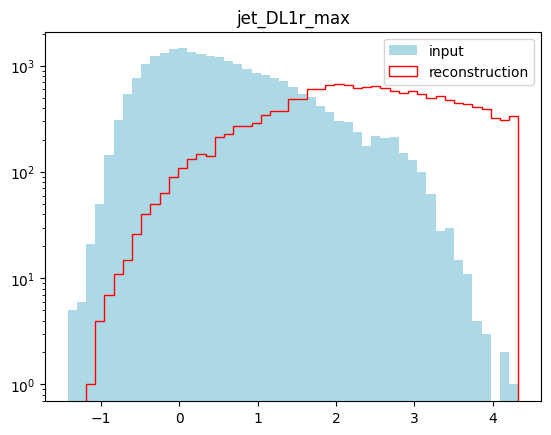

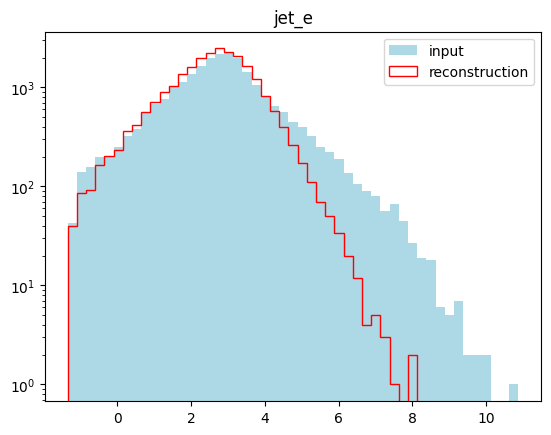

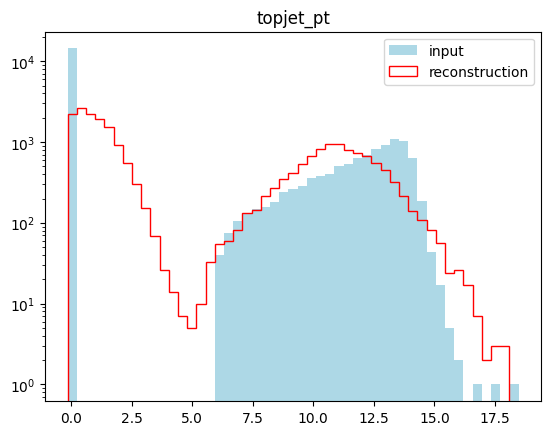

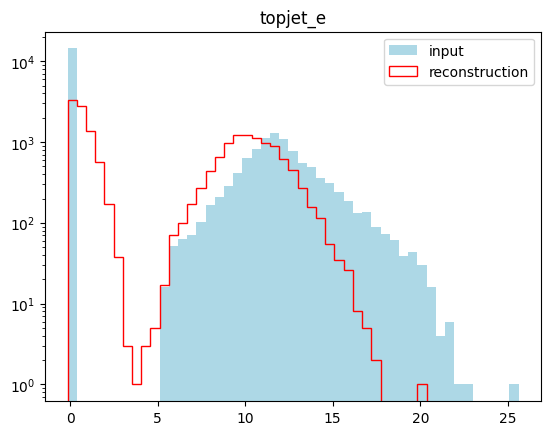

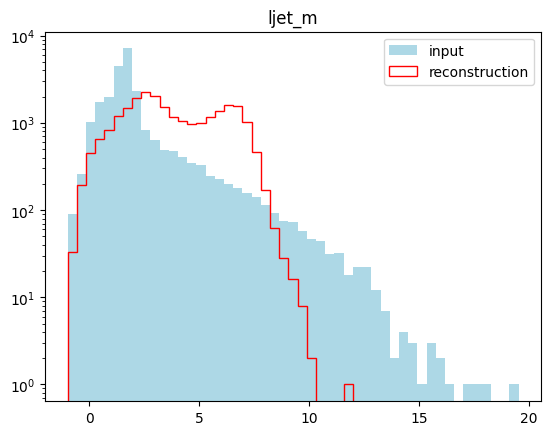

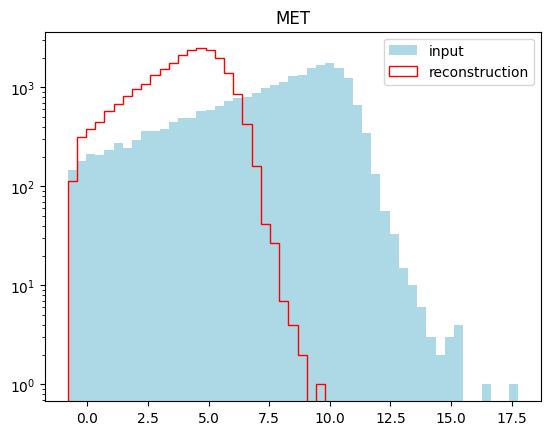

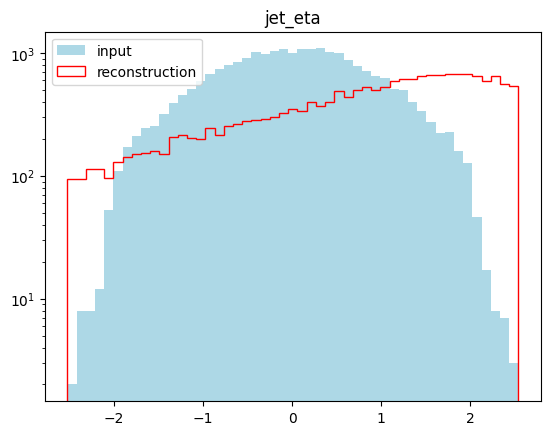

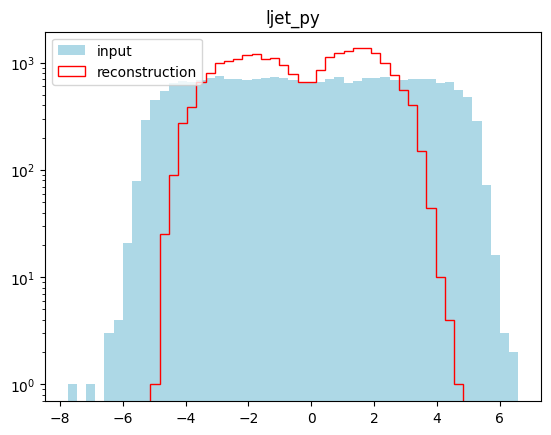

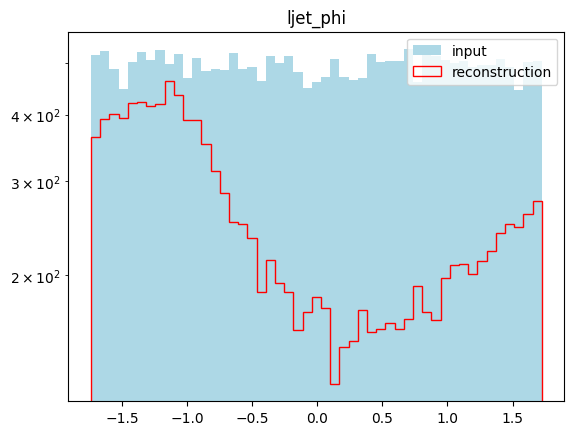

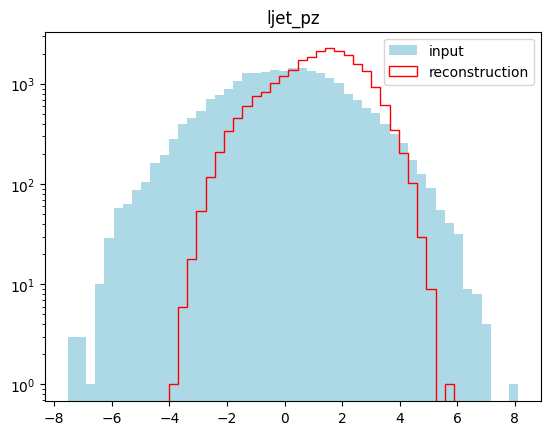

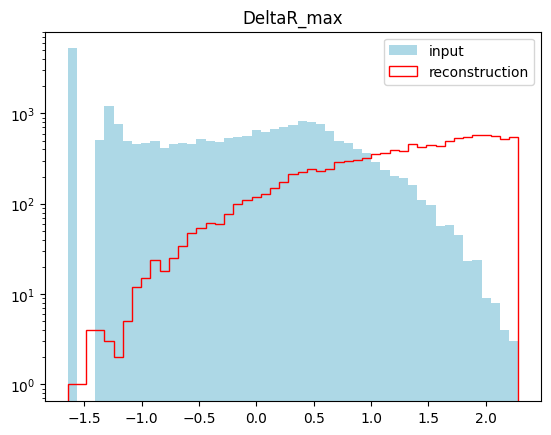

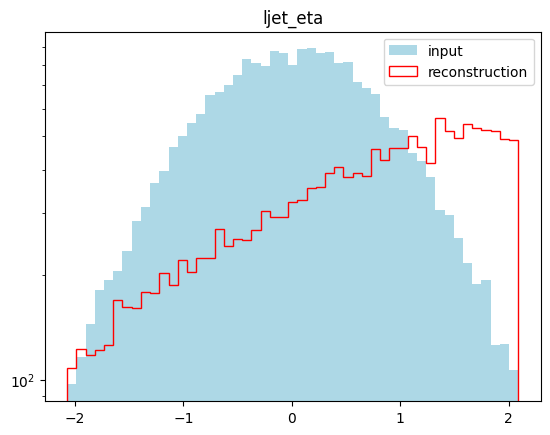

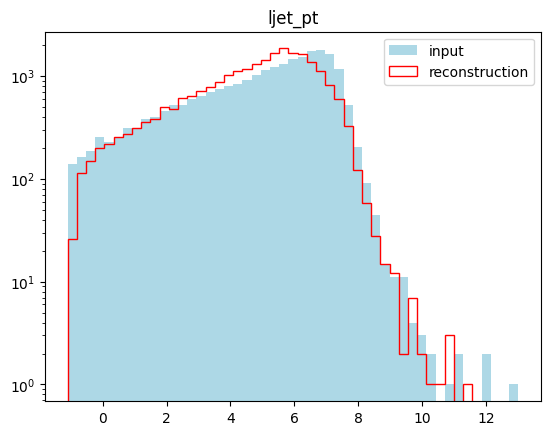

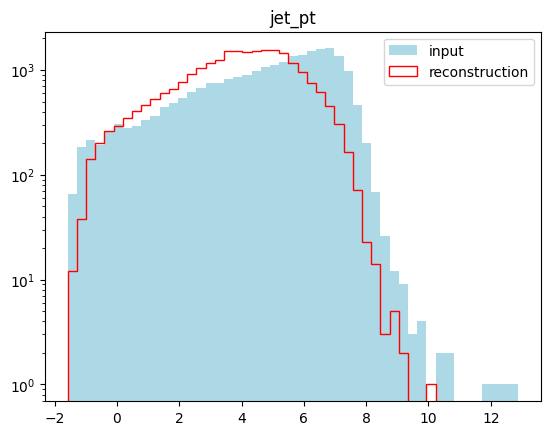

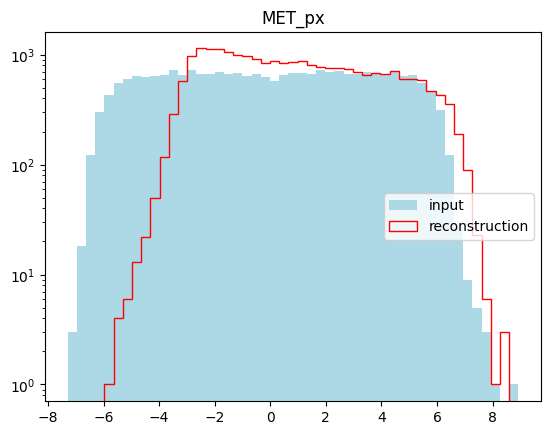

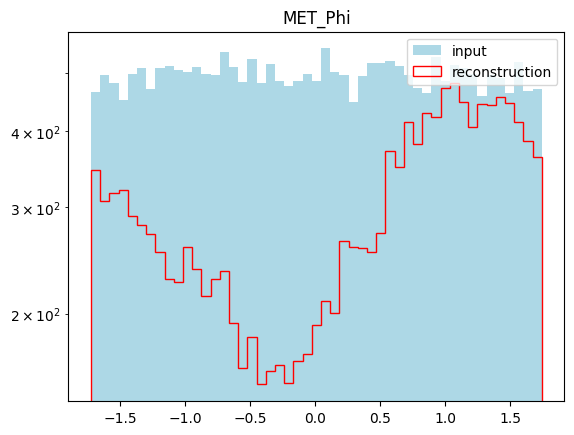

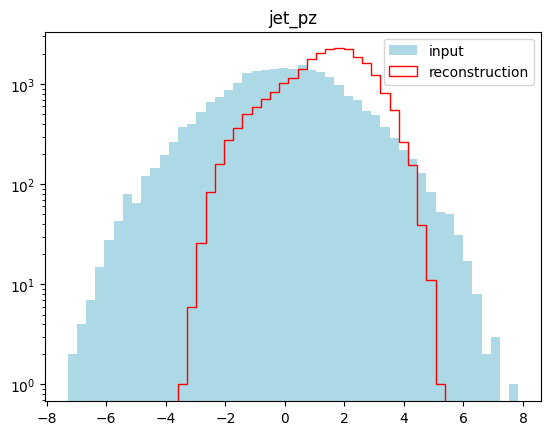

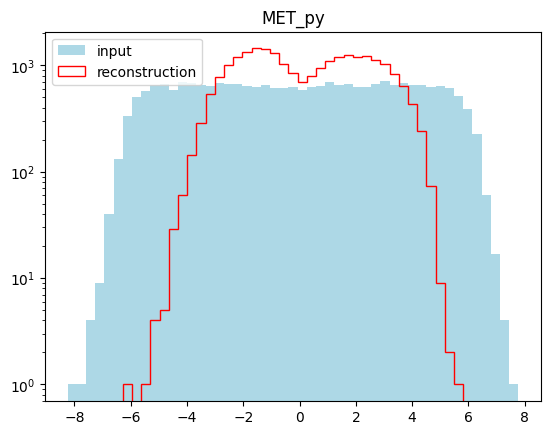

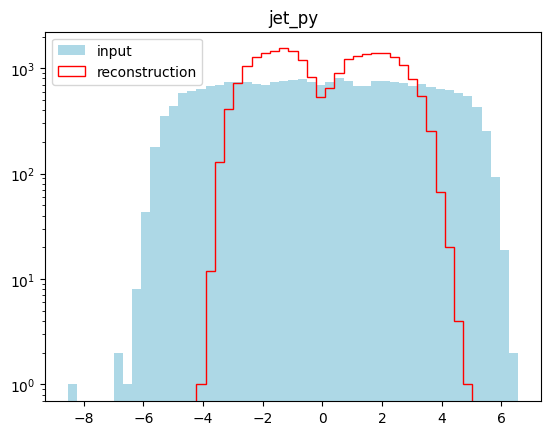

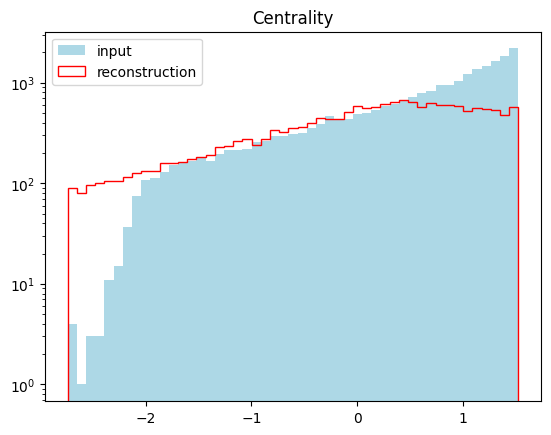

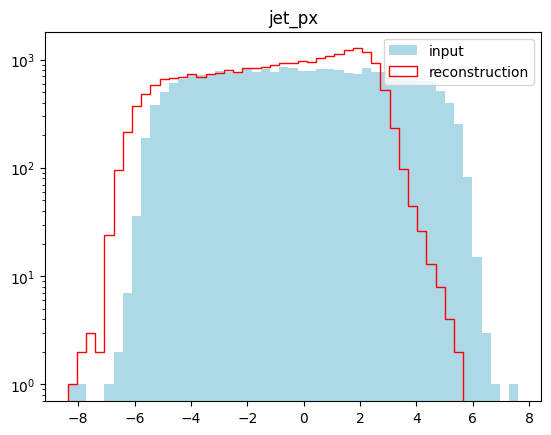

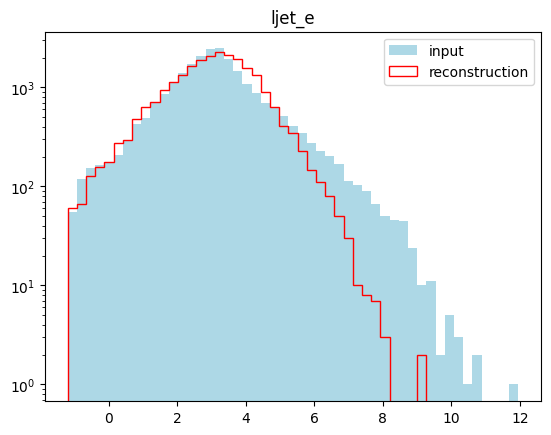

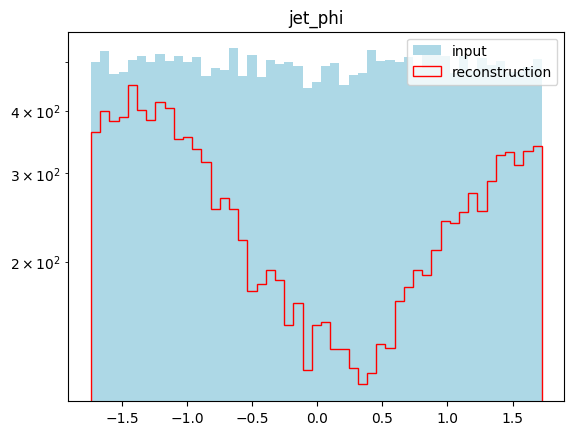

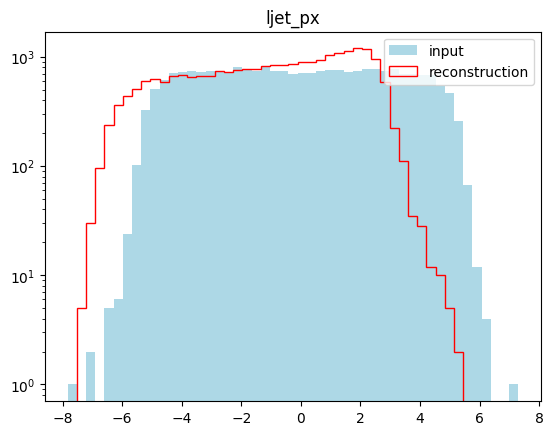

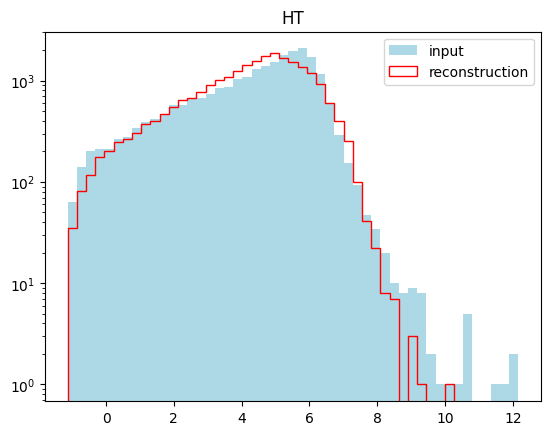

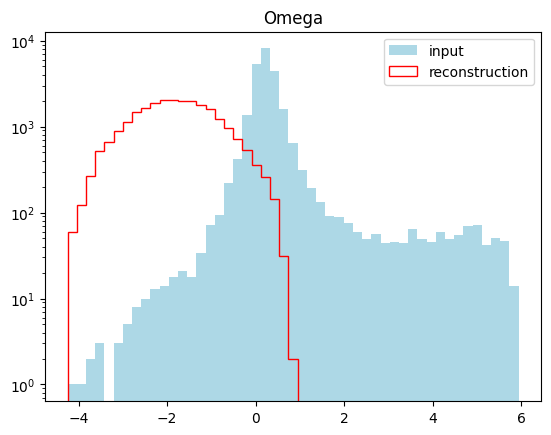

In [24]:
#Plotting reconstructed features
col=decoded_signalM.columns
for x in col:
    maxVal=testSignalM_df[x].max()
    minVal=testSignalM_df[x].min()
    binedges=np.linspace(minVal,maxVal,50)
    plt.hist(testSignalM_df[x],bins=binedges,label="input",color="#ADD8E6")
    plt.hist(decoded_signalM[x],bins=binedges,label= "reconstruction",color="red",histtype="step")
    plt.legend()
    plt.title(x)
    plt.yscale("log")
    plt.savefig((x+'signal reconstruction'))
    plt.show()

# Comparing monotop and background

I then plotted the mean squared error of the monotop signal and the background dataset on the same graph so that I could compare the two. As can be seen signal loss is much greater so the autoencoder has worked well as a technique for anomaly detection of signals of this type.

In [25]:
#comparing mean squared error

density=True
plt.hist(back_loss, bins=50,label="Background",histtype='stepfilled',color="#779ECB",alpha=0.5,density=density,weights=testWeightsBackground)
plt.hist(signalM_loss, bins=50,label="Signal",histtype='stepfilled',color="#e3342f",density=density,alpha=0.5)
plt.xlabel("Mean squared error")
plt.ylabel("No of events")
#plt.yscale("log")
plt.xlim(0,20)
plt.legend()
plt.savefig("loss of both")
plt.show()

In [26]:
print("Mean loss of background:",np.mean(back_loss))
print("Mean loss of signal:",np.mean(signalM_loss))

I then computed the same plot as above but this time using mean absolute error instead. This also shows a good splitting. I would like to extend this by calculating some ROC curves to numerically compare which is th ebest of the two methods.

In [27]:
#comparing mean absolute error
signalM_mae = tf.keras.losses.mae(decoded_signalM, testSignalM_scaled)
print("signal loss calculated")
back_mae = tf.keras.losses.mae(reconstructedBackground, testBackground_scaled)
print("background loss calculated")

density=True
plt.hist(back_mae, bins=50,label="Background",color="#779ECB",
         histtype='stepfilled',alpha=0.5,density=density,weights=testWeightsBackground)
plt.hist(signalM_mae, bins=50,label="Signal",histtype='stepfilled',color='#e3342f',density=density,alpha=0.5)
plt.xlabel("Mean Absolute Error")
plt.ylabel("No of events")
# plt.yscale("log")
plt.legend()
plt.xlim((0,4))
plt.savefig("loss of both")
plt.show()

signal loss calculated
background loss calculated


It is really important that the autoencoder is applicable to ther signal types. If it is not then it defeats the purpose of using it and you might as well just use the supervised method. In the cells below, I have applied the autoencoder to the three other signals which were imported at the begining. I have compared the mean absolute errors of each of these with that for background. All show a clear split menaing that the model has worked effectively for all of these signal types.


# Comparing gluino and background

In [28]:
decoded_signalG = autoencoder.predict(testSignalG_scaled)
decoded_signalG=pd.DataFrame(data=decoded_signalG, columns=testSignalG.columns)
print("Signal trained")

signalG_mae = tf.keras.losses.mae(decoded_signalG, testSignalG_scaled)
print("Loss calculated")

37/37 [==============================] - 0s 3ms/step
Signal trained
Loss calculated


In [29]:
density=True
plt.hist(back_mae, bins=50,label="Background",color="#779ECB",
         histtype='stepfilled',alpha=0.5,density=density,weights=testWeightsBackground)
plt.hist(signalG_mae, bins=50,label="Signal",histtype='stepfilled',color="#f6993f",density=density,alpha=0.5)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Normalised Number of Events")
# plt.yscale("log")
plt.legend()
plt.xlim((0,4))
plt.savefig("loss of both")
plt.show()

# Comparing triplets and background

In [30]:
decoded_signalT = autoencoder.predict(testSignalT_scaled)
decoded_signalT=pd.DataFrame(data=decoded_signalT, columns=testSignalT.columns)
print("Signal trained")

signalT_mae = tf.keras.losses.mae(decoded_signalT, testSignalT_scaled)
print("Loss calculated")

86/86 [==============================] - 0s 2ms/step
Signal trained
Loss calculated


In [31]:
density=True
plt.hist(back_mae, bins=50,label="Background",color="#779ECB",histtype='stepfilled',alpha=0.5,density=density,weights=testWeightsBackground)
plt.hist(signalT_mae, bins=50,label="Signal",histtype='stepfilled',color='#38c172',density=density,alpha=0.5)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Normalised Number of events")
# plt.yscale("log")
plt.legend() 
plt.xlim((0,4))
plt.savefig("loss of both")
plt.show()

# Comparing higgs and background

In [32]:
decoded_signalH = autoencoder.predict(testSignalH_scaled)
decoded_signalH=pd.DataFrame(data=decoded_signalH, columns=testSignalH.columns)
print("Signal trained")

signalH_mae = tf.keras.losses.mae(decoded_signalH, testSignalH_scaled)
print("Loss calculated")

83/83 [==============================] - 0s 2ms/step
Signal trained
Loss calculated


In [33]:
density=True
plt.hist(back_mae, bins=50,label="Background",color="#779ECB",
         histtype='stepfilled',alpha=0.5,density=density,weights=testWeightsBackground)
plt.hist(signalH_mae, bins=50,label="Signal",histtype='stepfilled',color='#f66d9b',density=density,alpha=0.5)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Normalised Number of Events")
# plt.yscale("log")
plt.legend()
plt.xlim((0,4))
plt.savefig("loss of both")
plt.show()

# Comparing all signals with background

I then plotted all losses on the same graph to allow for direct comparison. As seen they all have clear splits meaning that it has worked well. The monotop signal has performed the best as most of the data has separated clearly from backgeund and its peak is much more separated.

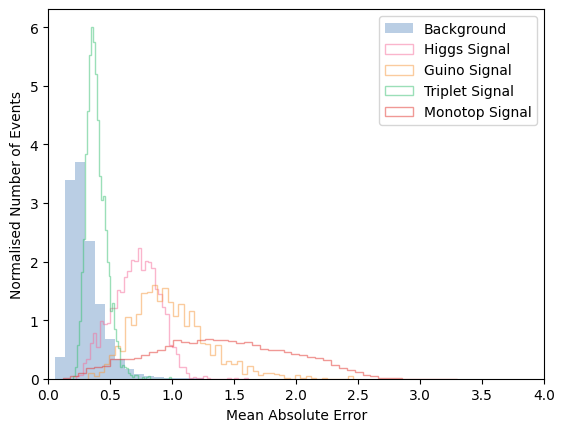

In [36]:
density=True
plt.hist(back_mae, bins=50,label="Background",histtype='stepfilled',alpha=0.5,density=density,weights=testWeightsBackground,color="#779ECB")
plt.hist(signalH_mae, bins=50,label="Higgs Signal",histtype='step',density=density,alpha=0.5,color='#f66d9b')
plt.hist(signalG_mae, bins=50,label="Guino Signal",histtype='step',density=density,alpha=0.5,color='#f6993f')
plt.hist(signalT_mae, bins=50,label="Triplet Signal",histtype='step',density=density,alpha=0.5,color='#38c172')
plt.hist(signalM_mae, bins=50,label="Monotop Signal",histtype='step',density=density,alpha=0.5,color='#e3342f')
plt.xlabel("Mean Absolute Error")
plt.ylabel("Normalised Number of Events")
# plt.yscale("log")
plt.legend()
plt.xlim((0,4))
plt.savefig("loss of both")
plt.show()

# Plotting the reconstructions of each feature for all signals 

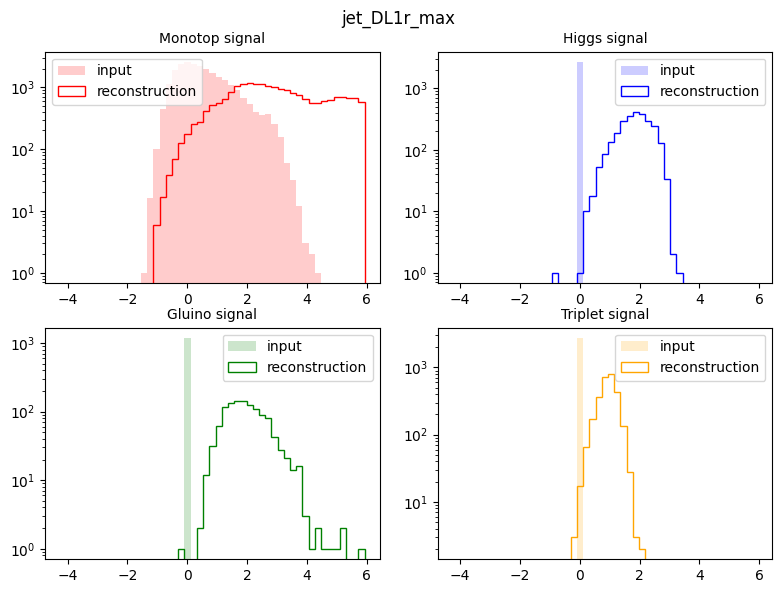

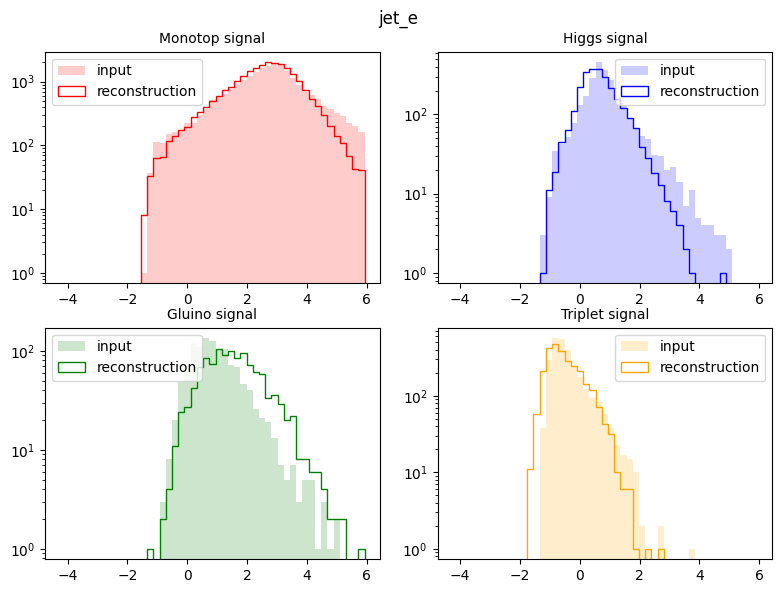

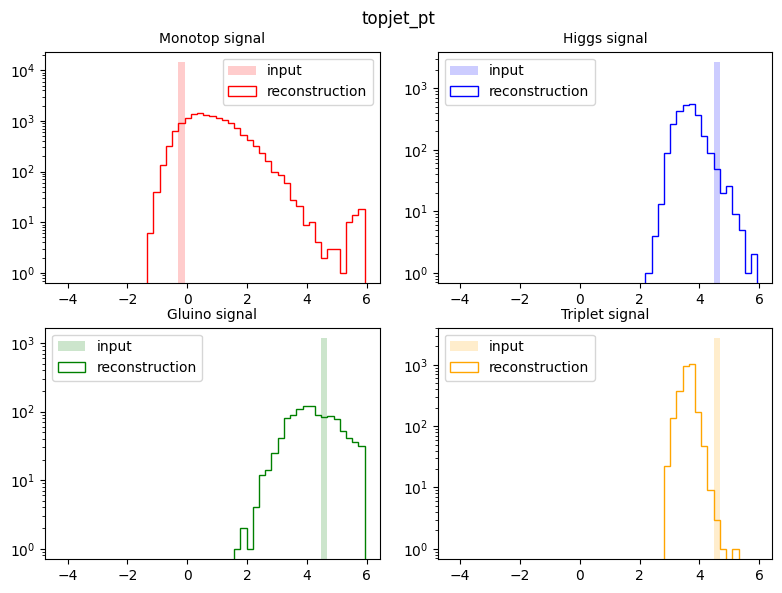

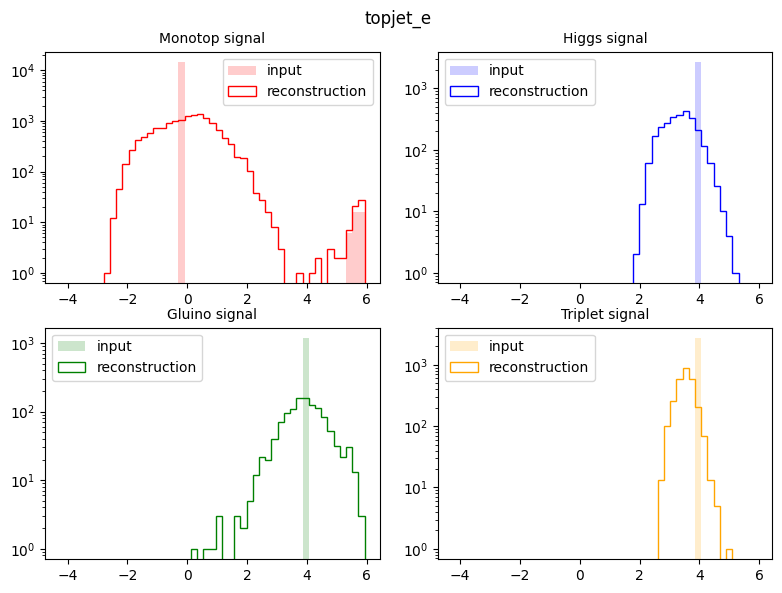

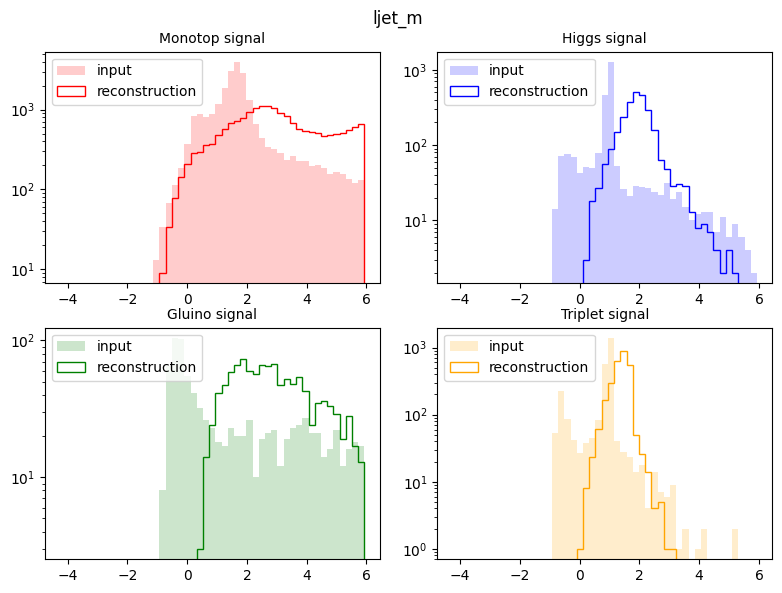

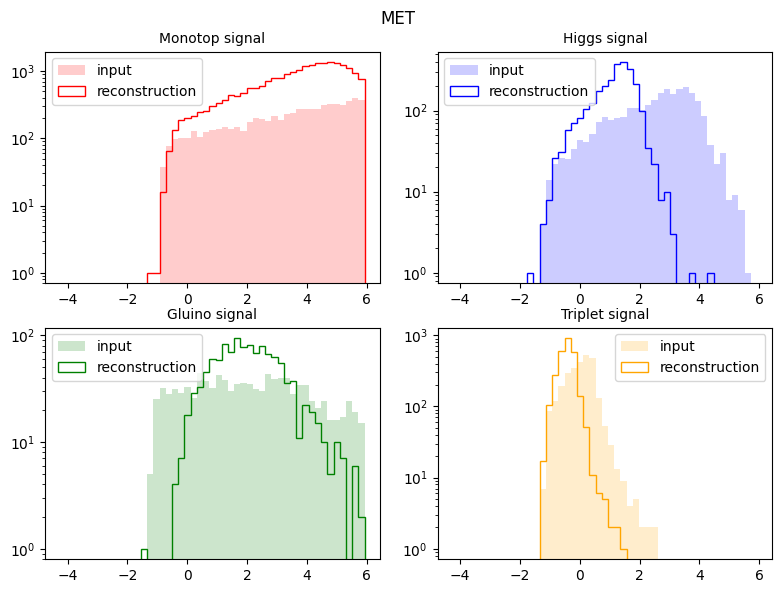

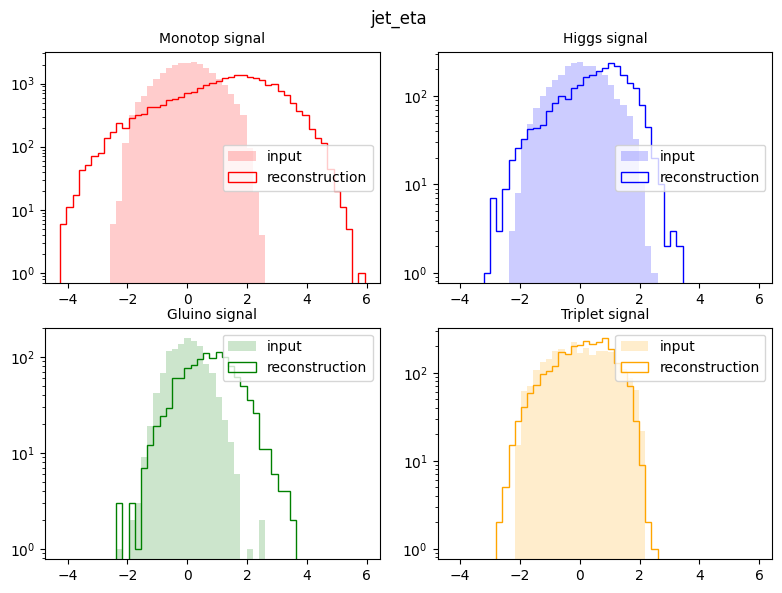

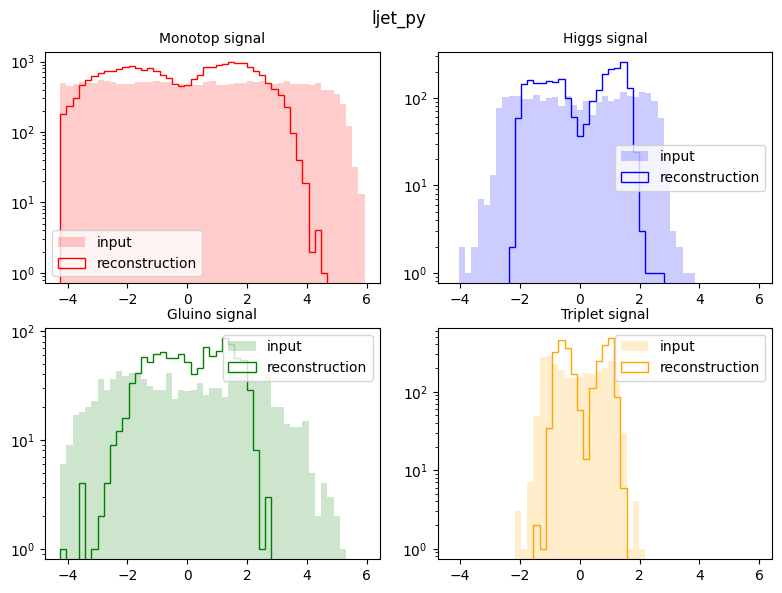

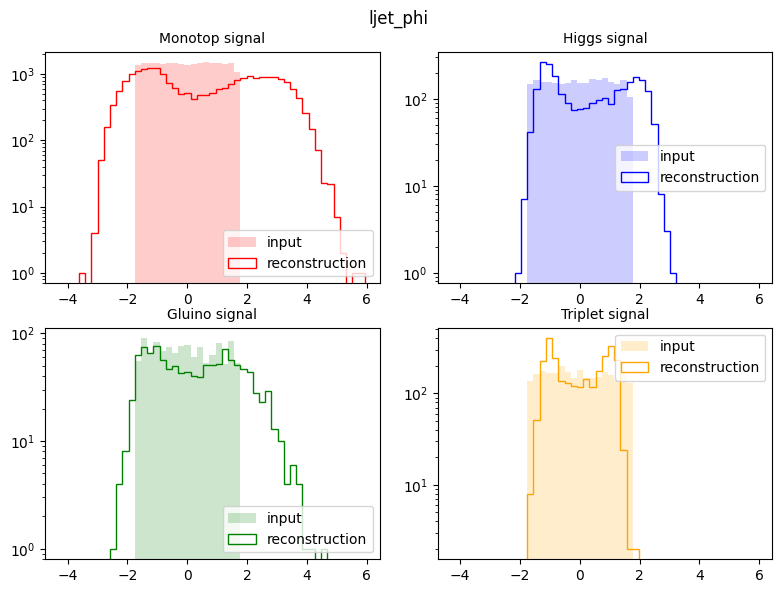

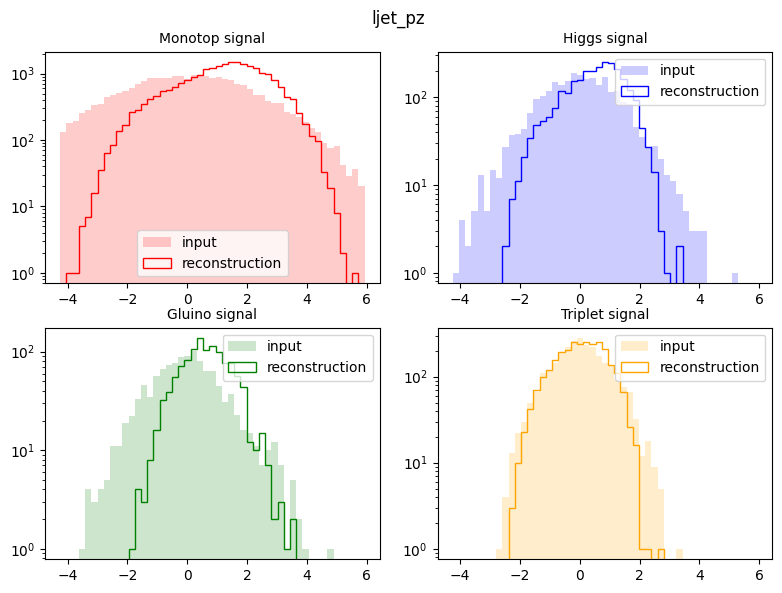

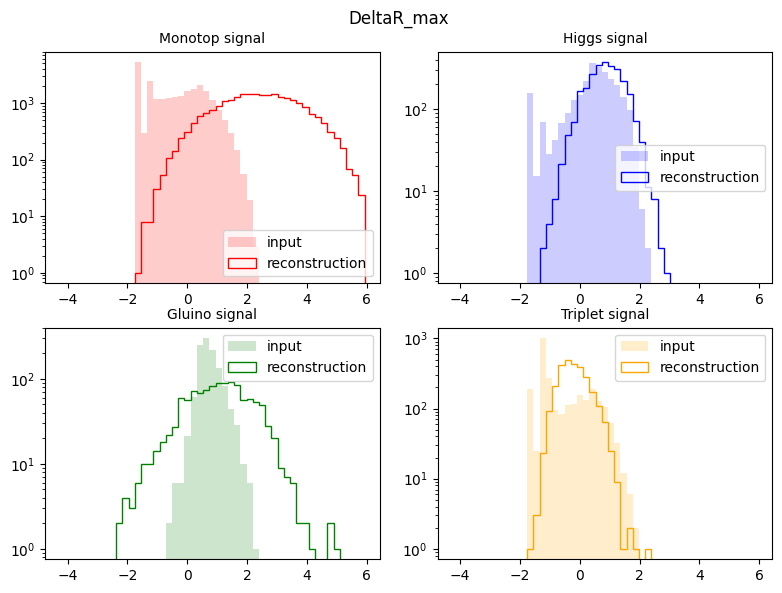

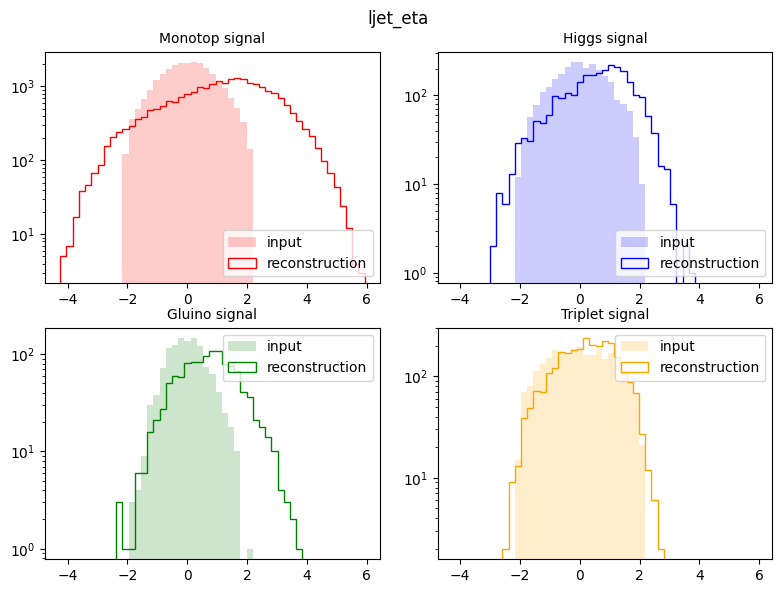

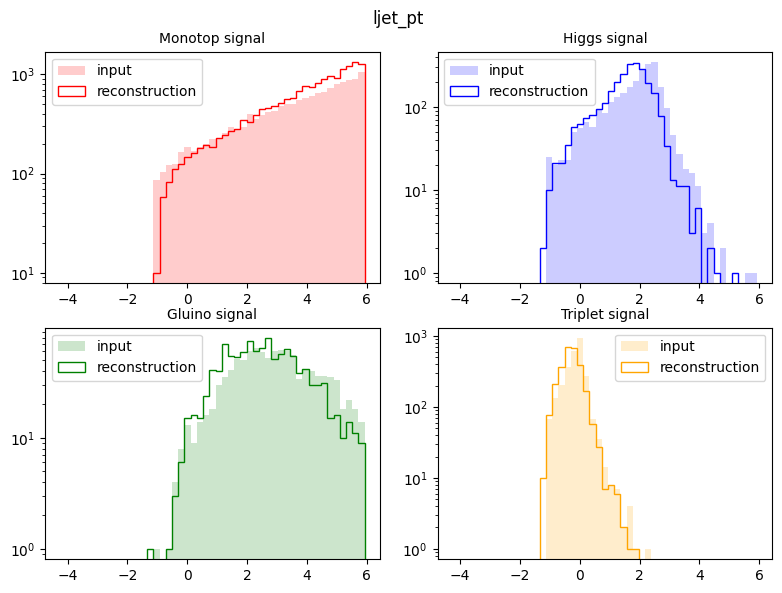

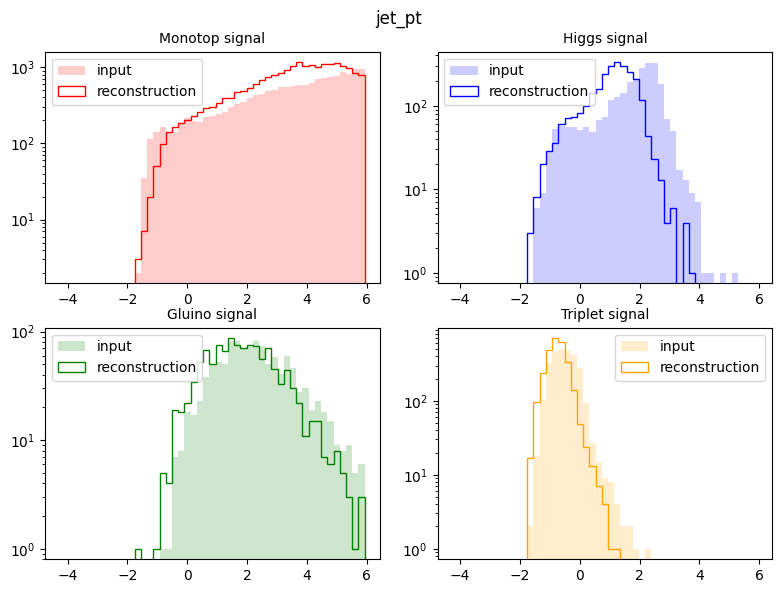

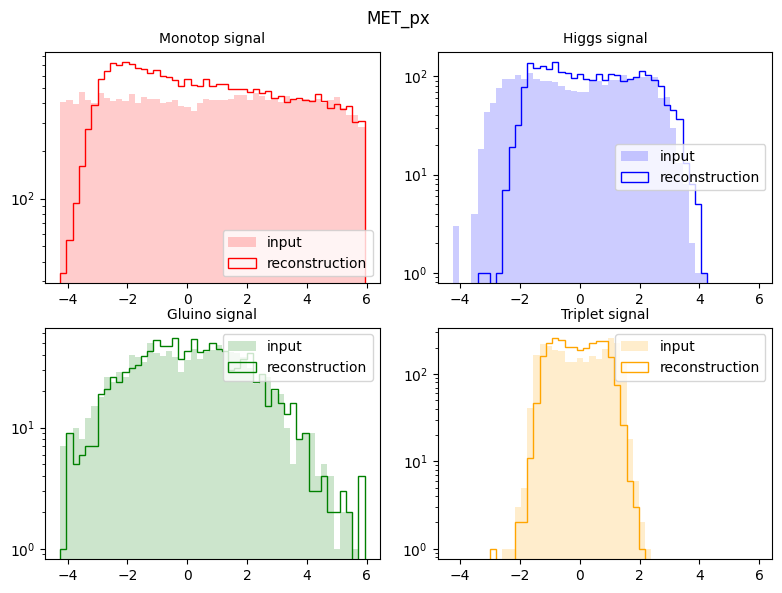

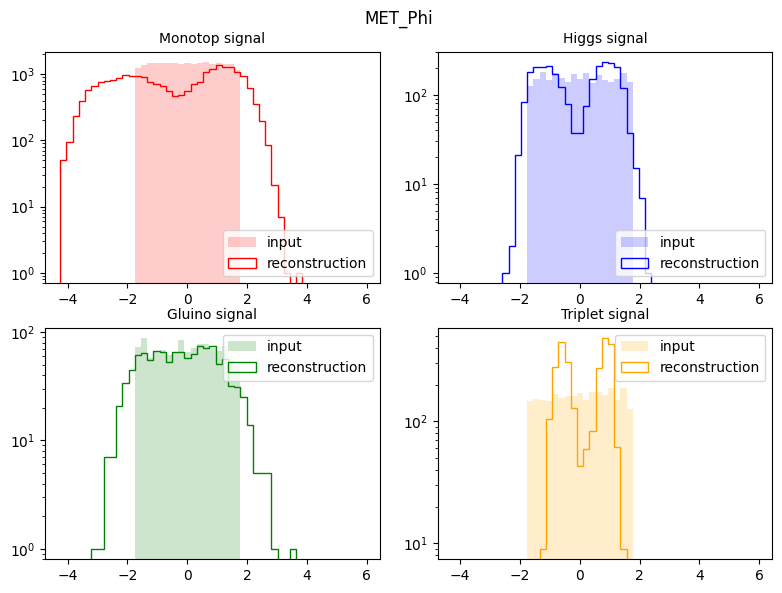

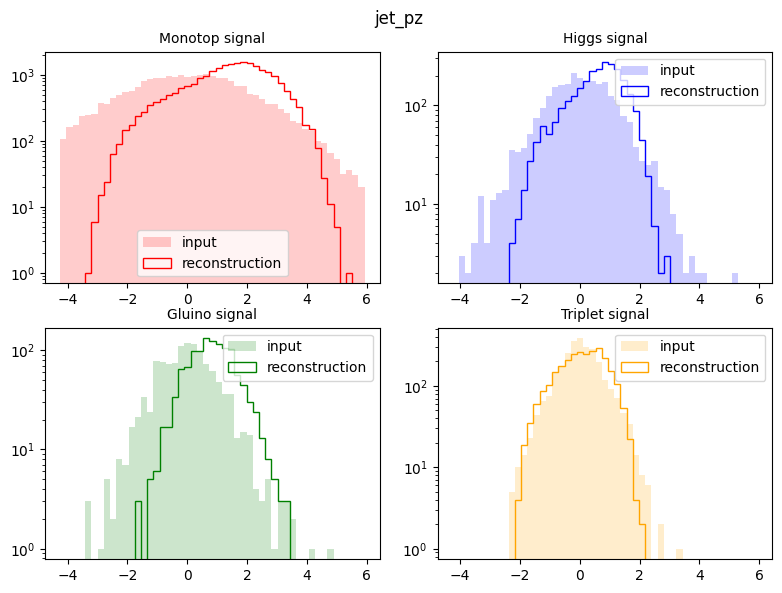

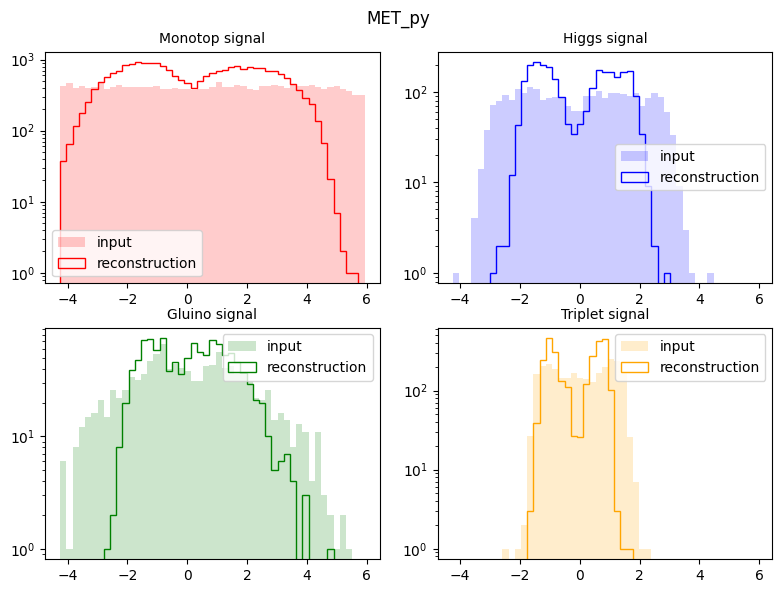

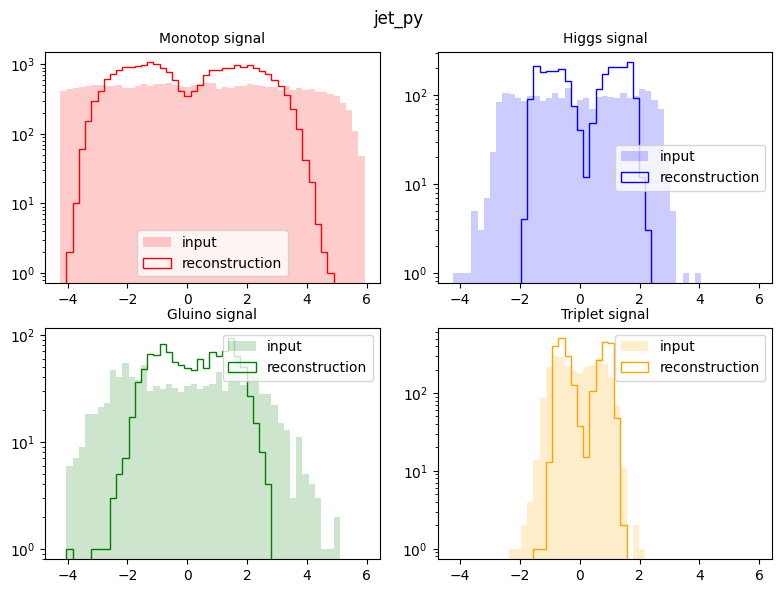

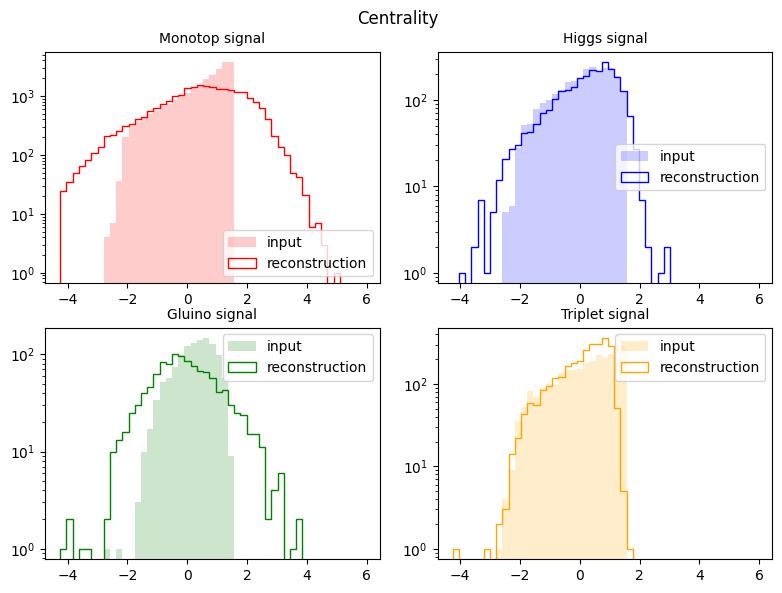

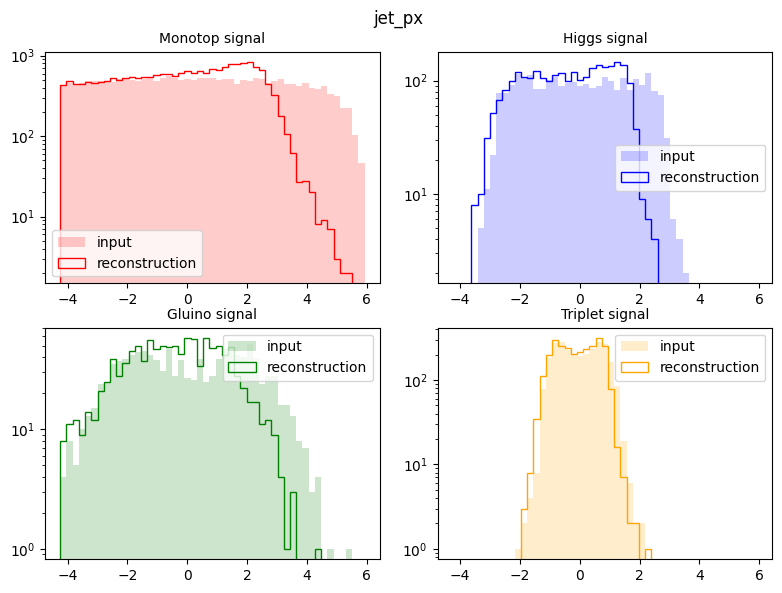

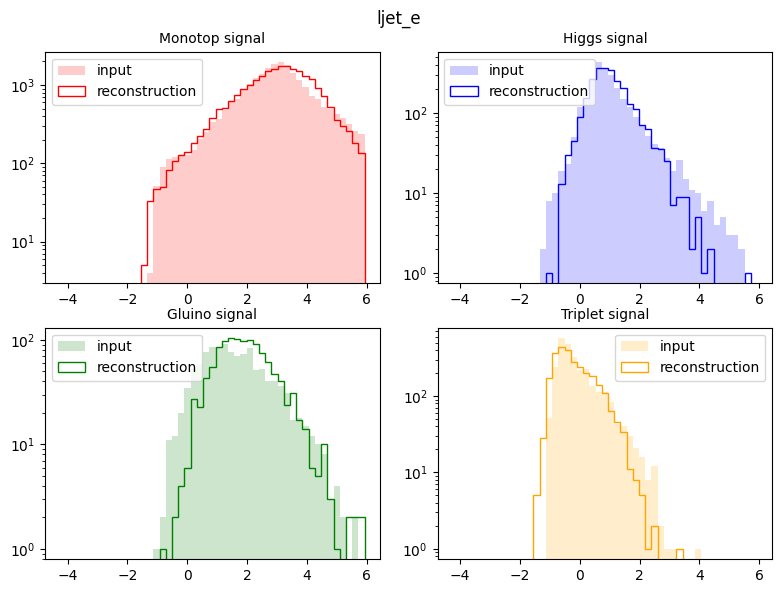

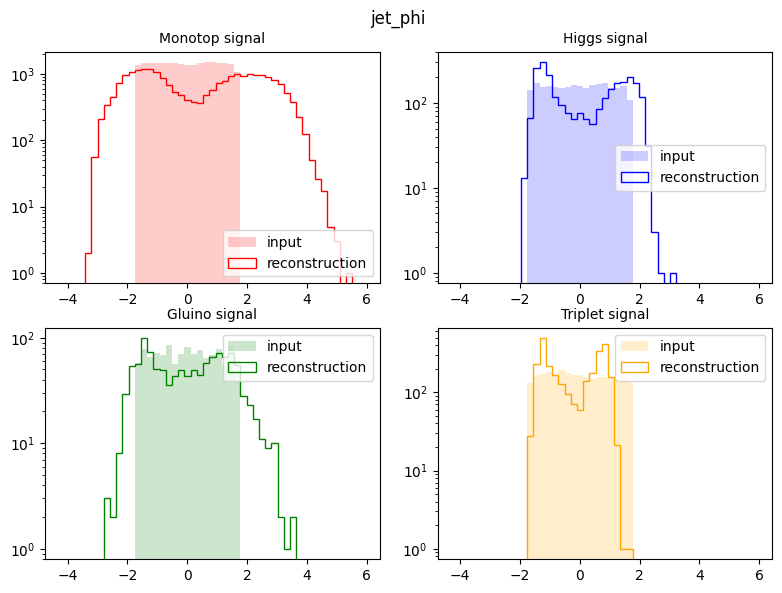

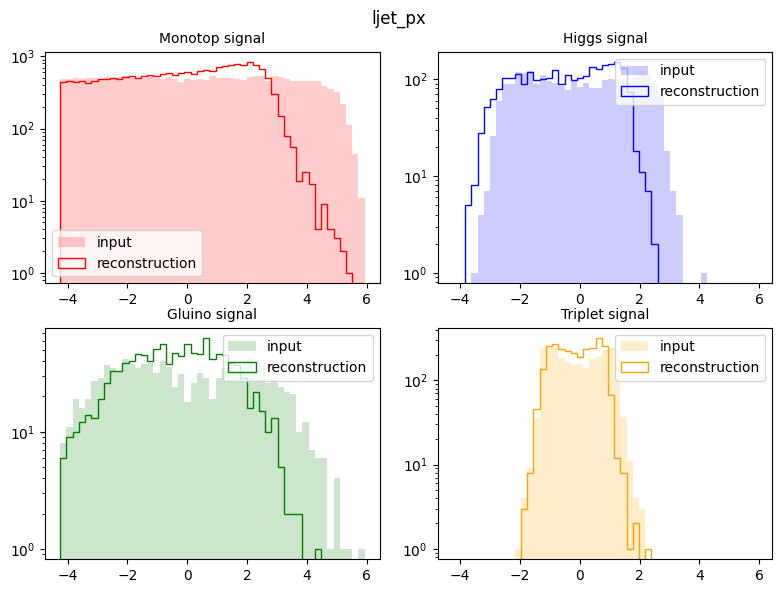

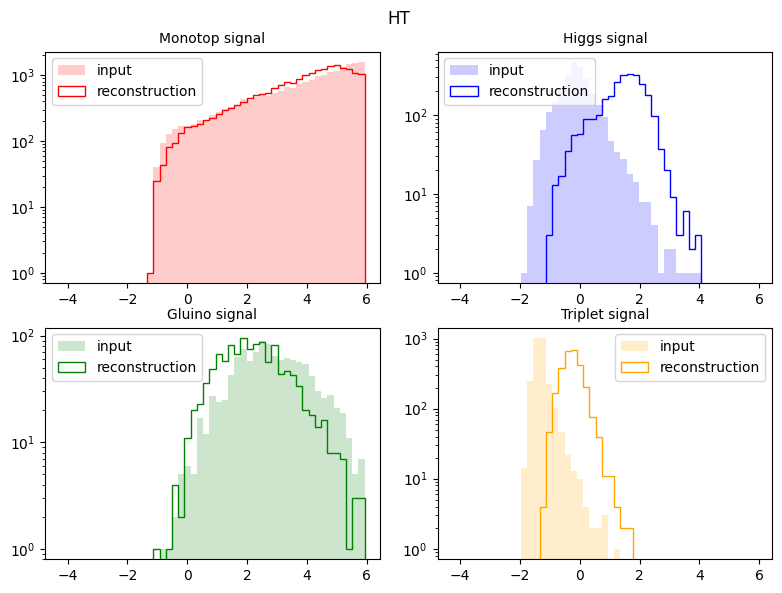

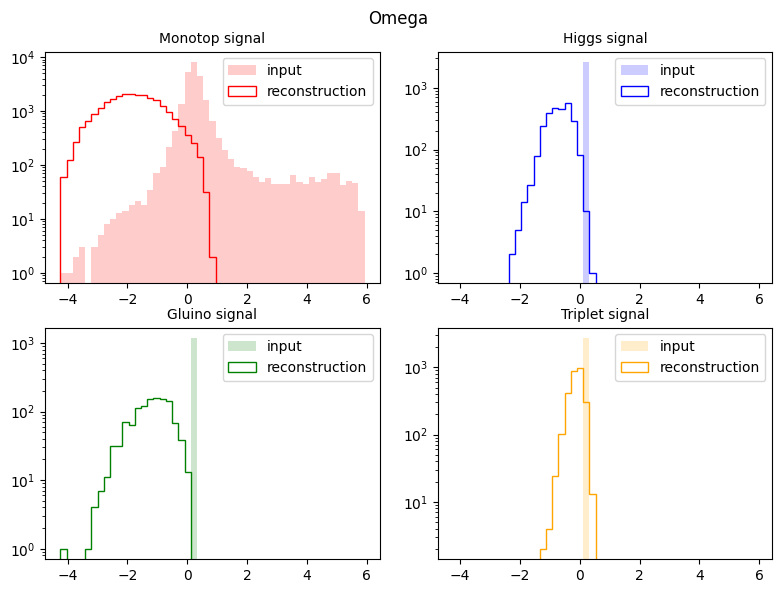

In [37]:

#Plotting reconstructed features
col=decoded_signalM.columns
for x in col:
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
    fig.suptitle(x)
    fig.tight_layout()
    
    ax0.hist(testSignalM_df[x],bins=binedges,label="input",color="red",alpha=0.2)
    ax0.hist(decoded_signalM[x],bins=binedges,label= "reconstruction",color="red",histtype="step")
    ax0.set_title('Monotop signal',fontsize=10)
    ax0.set_yscale('log')
    ax0.legend()
    
    ax1.hist(testSignalH_df[x],bins=binedges,label="input",color="blue",alpha=0.2)
    ax1.hist(decoded_signalH[x],bins=binedges,label= "reconstruction",color="blue",histtype="step")
    ax1.set_title('Higgs signal',fontsize=10)
    ax1.set_yscale('log')
    ax1.legend()
    
    ax2.hist(testSignalG_df[x],bins=binedges,label="input",color="green",alpha=0.2)
    ax2.hist(decoded_signalG[x],bins=binedges,label= "reconstruction",color="green",histtype="step")
    ax2.set_title('Gluino signal',fontsize=10)
    ax2.set_yscale('log')
    ax2.legend()
    
    ax3.hist(testSignalT_df[x],bins=binedges,label="input",color="orange",alpha=0.2)
    ax3.hist(decoded_signalT[x],bins=binedges,label= "reconstruction",color="orange",histtype="step")
    ax3.set_title("Triplet signal",fontsize=10)
    ax3.set_yscale('log')
    ax3.legend()
    
    plt.legend()
    plt.yscale("log")
    plt.savefig((x+'signal reconstruction'))
    plt.show()
    print("\n")

# Plotting ROC Curves

ROC curves were then produced to numerically compare performance of the autoencoder for each signal

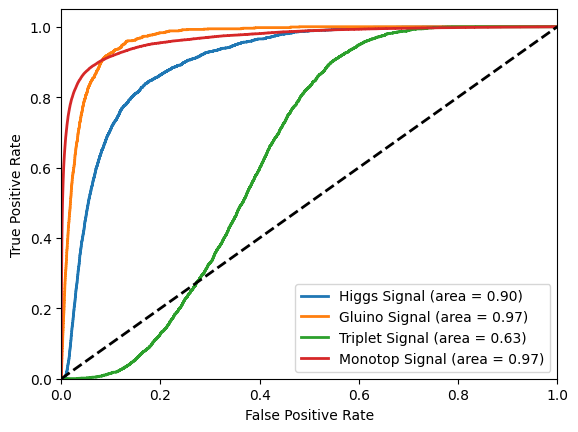

In [64]:
from sklearn.metrics import *

y_scoreH=np.concatenate((signalH_mae,back_mae))
y_trueH = np.concatenate((testSignalHLabel,testBackgroundLabel))
fprH, tprH, thresholds = roc_curve(y_trueH, y_scoreH)
roc_aucH = auc(fprH, tprH)

y_scoreT=np.concatenate((signalT_mae,back_mae))
y_trueT = np.concatenate((testSignalTLabel,testBackgroundLabel))
fprT, tprT, thresholds = roc_curve(y_trueT, y_scoreT)
roc_aucT = auc(fprT, tprT)

y_scoreG=np.concatenate((signalG_mae,back_mae))
y_trueG = np.concatenate((testSignalGLabel,testBackgroundLabel))
fprG, tprG, thresholds = roc_curve(y_trueG, y_scoreG)
roc_aucG = auc(fprG, tprG)

y_scoreM=np.concatenate((signalM_mae,back_mae))
y_trueM = np.concatenate((testSignalMLabel,testBackgroundLabel))
fprM, tprM, thresholds = roc_curve(y_trueM, y_scoreM)
roc_aucM = auc(fprM, tprM)

plt.figure()
lw = 2
plt.plot(fprH, tprH, lw=lw, label='Higgs Signal (area = %0.2f)' % roc_aucH)
plt.plot(fprG, tprG, lw=lw, label='Gluino Signal (area = %0.2f)' % roc_aucG)
plt.plot(fprT, tprT, lw=lw, label='Triplet Signal (area = %0.2f)' % roc_aucT)
plt.plot(fprM, tprM, lw=lw, label='Monotop Signal (area = %0.2f)' % roc_aucM)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--',color="black")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

